In [1]:
import gc
from typing import Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lsst.rsp import get_tap_service
from lsst.daf.butler import Butler

In [2]:
service = get_tap_service("tap")
butler = Butler("dp1", collections="LSSTComCam/DP1")

# Afterglow simulation over DP1 data

The goal of this notebook is to rework and improve our basic simulation of GRB afterglow over Rubin images. 
This time we will:

* Work on the pictures from the DP1 dataset, real sky images gathered with the Rubin ComCam camera.
* Rather than inferring simple, uniform distribution, we bootstrap the dataset of Kann et al.
* Simulate the afterglow lightcurve and spectra, using `afterglowpy`.
* Generate a whole week of images, in a way more representative of the expected true scenario.

## Finding suitable time and sky directions

Let's start by investigating the DP1 visit table. The goal is to identify a sky direction and time span which was imaged a a few times over a week, in different bands. The plan is this. We limit ourselves to the best covered DP1 skyfield: the _Extended Chandra Deep Field South_ (ECDFS). We write a function which shall take a sky coordinate and a time span and return a dictionary `{band: counts}` of the visits received by that point over the timespan (or the entire dataset).

In [3]:
from bisect import bisect

from lsst.daf.butler import Butler, Timespan, DatasetRef
from astropy.time import Time


def argwhere(haystack: list[int], needle: int):
    assert needle in haystack
    return bisect(haystack, needle) - 1


def fetch_visits(ra: float, dec: float, ti: Time, tf: Time) -> list[DatasetRef]:
    butler = Butler("dp1", collections="LSSTComCam/DP1")
    dataset_refs = butler.query_datasets(
        "visit_image",
        where=(
            "visit_detector_region.region OVERLAPS POINT(:ra, :dec) AND " 
            "visit.timespan OVERLAPS :timespan"
        ),
        bind={"ra": ra, "dec": dec, "timespan": Timespan(ti, tf)},
        order_by=["visit.timespan.begin",],
    )
    return dataset_refs

def fetch_differences(visits_refs: list[DatasetRef]) -> list[DatasetRef]:
    butler = Butler("dp1", collections="LSSTComCam/DP1")
    visit_ids = [ref.dataId["visit"] for ref in visits_refs]
    visit_ids_str = "(" + ", ".join(map(str, visit_ids)) + ")"
    
    # Query for all difference images matching the visit IDs.
    # Note: This may return refs from detectors not present in visits_refs,
    # so len(dataset_refs) >= len(visits_refs)
    dataset_refs = butler.query_datasets(
        "difference_image",
        where=f"visit.id IN {visit_ids_str}"
    )
    # Map each (visit, detector) pair to its position in the original list
    visit_detector_to_index = {
        (ref.dataId["visit"], ref.dataId["detector"]): i 
        for i, ref in enumerate(visits_refs)
    }
    # Filter to keep only difference images with matching (visit, detector) pairs
    matching_refs = [
        ref for ref in dataset_refs 
        if (ref.dataId["visit"], ref.dataId["detector"]) in visit_detector_to_index
    ]
    # Sort by original order since the query doesn't preserve it
    return sorted(
        matching_refs,
        key=lambda ref: visit_detector_to_index[(ref.dataId["visit"], ref.dataId["detector"])]
    )

def count_perband_visits(dataset_refs: list[DatasetRef]):
    counts = {}
    for band in map(lambda x: x.dataId["band"], dataset_refs):
        counts[band] = counts.setdefault(band, 0) + 1
    return counts

In [4]:
from astropy.time import TimeDelta

ra, dec =  106.3, -10.4
ti = Time("2024-12-01T00:00:00.0", format="isot", scale="tai")
tf = ti + TimeDelta(7, format="jd")  # days

visits_refs = fetch_visits(ra, dec, ti, tf)
diff_refs = fetch_differences(visits_refs)
count_perband_visits(visits_refs)

{'r': 5, 'g': 5, 'u': 8}

Looks good.

## Simulating the afterglow lightcurve

We will use the `afterglowpy` package for this purpose, simulating the lightcurve fading over 14 days, in the UGRIZY bands.

In [5]:
import afterglowpy as grb

bands_freq = {
    "u": 8.2e14,
    "g": 6.5e14,
    "r": 4.6e14,
    "i": 3.7e14,
    "z": 3.3e14,
    "y": 2.9e14,
}

# as i mostly ignore the meaning of these, i will  use the same 
# parameters used in the demo script `example/plotLightCurve.py`
# with the exception of the luminosity distance, which i decreased 
# in order to make the transient brighter
Z = {
    'jetType':     grb.jet.TopHat,     # Top-Hat jet
    'specType':    grb.jet.SimpleSpec, # Basic Synchrotron Emission Spectrum
    'thetaObs':    0.05,   # Viewing angle in radians
    'E0':          1.0e53, # Isotropic-equivalent energy in erg
    'thetaCore':   0.1,    # Half-opening angle in radians
    'n0':          1.0,    # circumburst density in cm^{-3}
    'p':           2.2,    # electron energy distribution index
    'epsilon_e':   0.1,    # epsilon_e
    'epsilon_B':   0.01,   # epsilon_B
    'xi_N':        1.0,    # Fraction of electrons accelerated
    'd_L':         1.0e26, # Luminosity distance in cm. [oroginally 1.0e28]
    'z':           0.55,   # redshift
}

t = np.geomspace(1.0e-1 * grb.day2sec, 14 * grb.day2sec, num=100)
tday = t * grb.sec2day
fdens = {label: grb.fluxDensity(t, eff_freq, **Z)for label, eff_freq in bands_freq.items()}

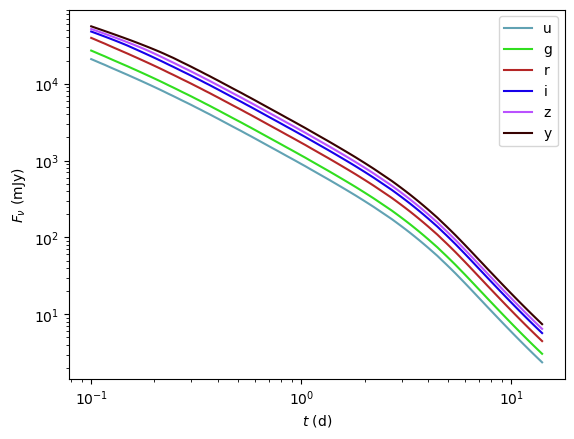

In [6]:
from lsst.utils.plotting import get_multiband_plot_colors

filter_colors = get_multiband_plot_colors()

fig, ax = plt.subplots(1, 1)
for band, fden in fdens.items():
    ax.plot(tday, fden, ls='-', label=rf'{band}', color=filter_colors[band])
ax.set(xscale='log', xlabel=r'$t$ (d)', yscale='log', ylabel=r'$F_\nu$ (mJy)')
ax.legend()
plt.show()

## Injection

In this section we are going to inject a realistic afterglow counterpart onto images from the DP1 catalog.

First, we gather all images from the butler in the space-time domain we defined at top of the notebook./

In [7]:
# may take a while..
visits = [butler.get(vr) for vr in visits_refs]
diffs = [butler.get(dr) for dr in diff_refs]

We set time for the burst one hour before the first picture time. Then we compute a quantities (time from burst, band, afterglow flux and magnitude according to the simulated light curve) to associate to each visit image. 

In [8]:
time_burst = butler.get(visits_refs[0]).visitInfo.date.toAstropy() - TimeDelta(1 / 24, format="jd")

times_visits_from_burst = [v.visitInfo.date.toAstropy() - time_burst for v in visits]
bands_visits = [v.filter.bandLabel for v in visits]
fden_visits = [grb.fluxDensity(t.value * grb.day2sec, bands_freq[b], **Z)[0] for t, b in zip(times_visits_from_burst, bands_visits)]
mag_visits = [v.getPhotoCalib().instFluxToMagnitude(f) for v, t, f in zip(visits, times_visits_from_burst, fden_visits)]

Let's plot the source intensities to be expected for each picture.

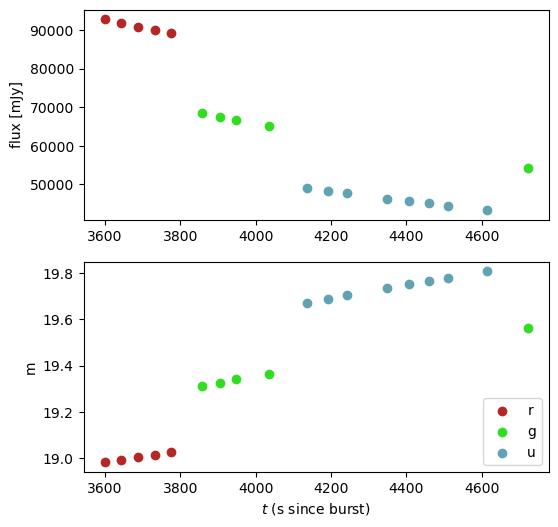

In [9]:
from lsst.utils.plotting import get_multiband_plot_colors

filter_colors = get_multiband_plot_colors()


_fdens, _ts, _mags = {}, {}, {}
for b, t, v in zip(bands_visits, times_visits_from_burst, visits):
    fden =  grb.fluxDensity(t.value * grb.day2sec, bands_freq[b], **Z)[0]
    _fdens.setdefault(b, []).append(fden)
    _mags.setdefault(b, []).append(v.getPhotoCalib().instFluxToMagnitude(fden))
    _ts.setdefault(b, []).append(t.value)
    
_fdens = {k: np.array(v) for k, v in _fdens.items()}
_mags = {k: np.array(v) for k, v in _mags.items()}
_ts = {k: np.array(v) for k, v in _ts.items()}


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
for band, fden in _fdens.items():
    ax1.scatter(_ts[band] * grb.day2sec, _fdens[band], ls='-', label=rf'{band}', color=filter_colors[band])
    ax2.scatter(_ts[band] * grb.day2sec, _mags[band], ls='-', label=rf'{band}', color=filter_colors[band])
ax1.set(ylabel=r"flux [mJy]")
ax2.set(xlabel=r'$t$ (s since burst)', ylabel=r"m")
ax2.legend(loc=4)
plt.show()

Inject over one visit.

In [10]:
from doppelganger.doppelganger.rubin.inject import inject

i = 0
visit_injected, _ = inject((visit := visits[i]), ra, dec,  mag_visits[i])
diff_injected, _ = inject((diff := diffs[i]), ra, dec,  mag_visits[i])

`DetectAndMeasureTask` require science, template and diff image. For DP1, we do not have templates. Template and science images are used for characterizing dipoles. This is a dirty trick to make a template which should make sense.

In [45]:
from lsst.afw.image import ImageF

template = visit_injected.clone()
template.setImage(ImageF(visit_injected.getImage().array - diff_injected.getImage().array))

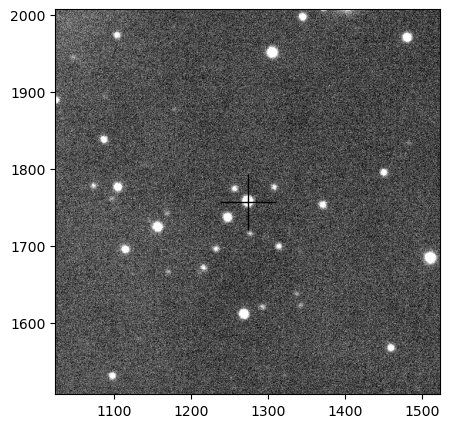

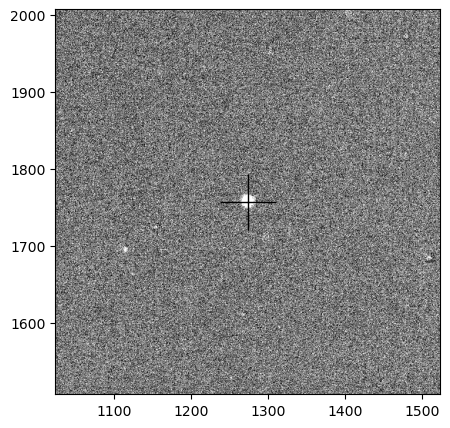

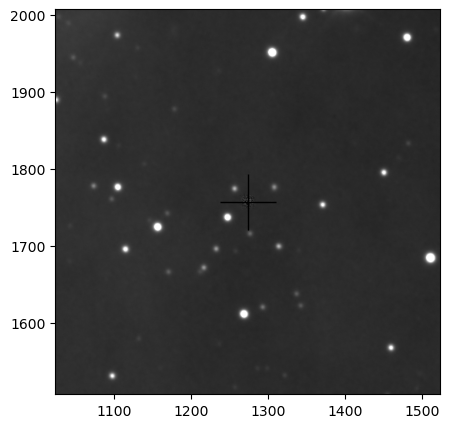

In [57]:
from doppelganger.doppelganger.rubin.utils import plot_zoom, remove_figure

remove_figure(plot_zoom(visit_injected, ra, dec, scale=2, side_px=500, figsize=(5, 5)))
remove_figure(plot_zoom(diff_injected, ra, dec, scale=1, side_px=500, figsize=(5, 5)))
remove_figure(plot_zoom(template, ra, dec, scale=1, side_px=500, figsize=(5, 5)))

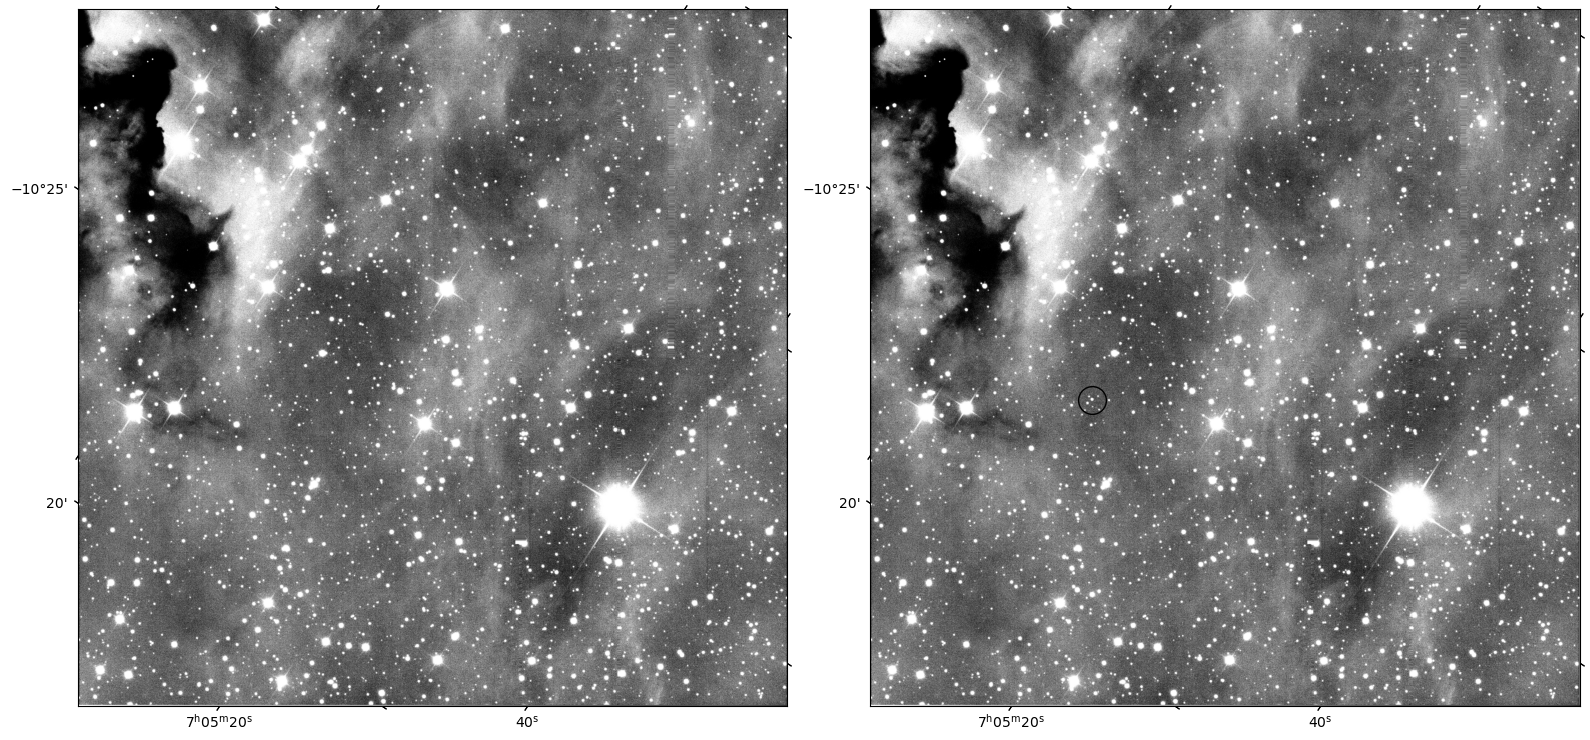

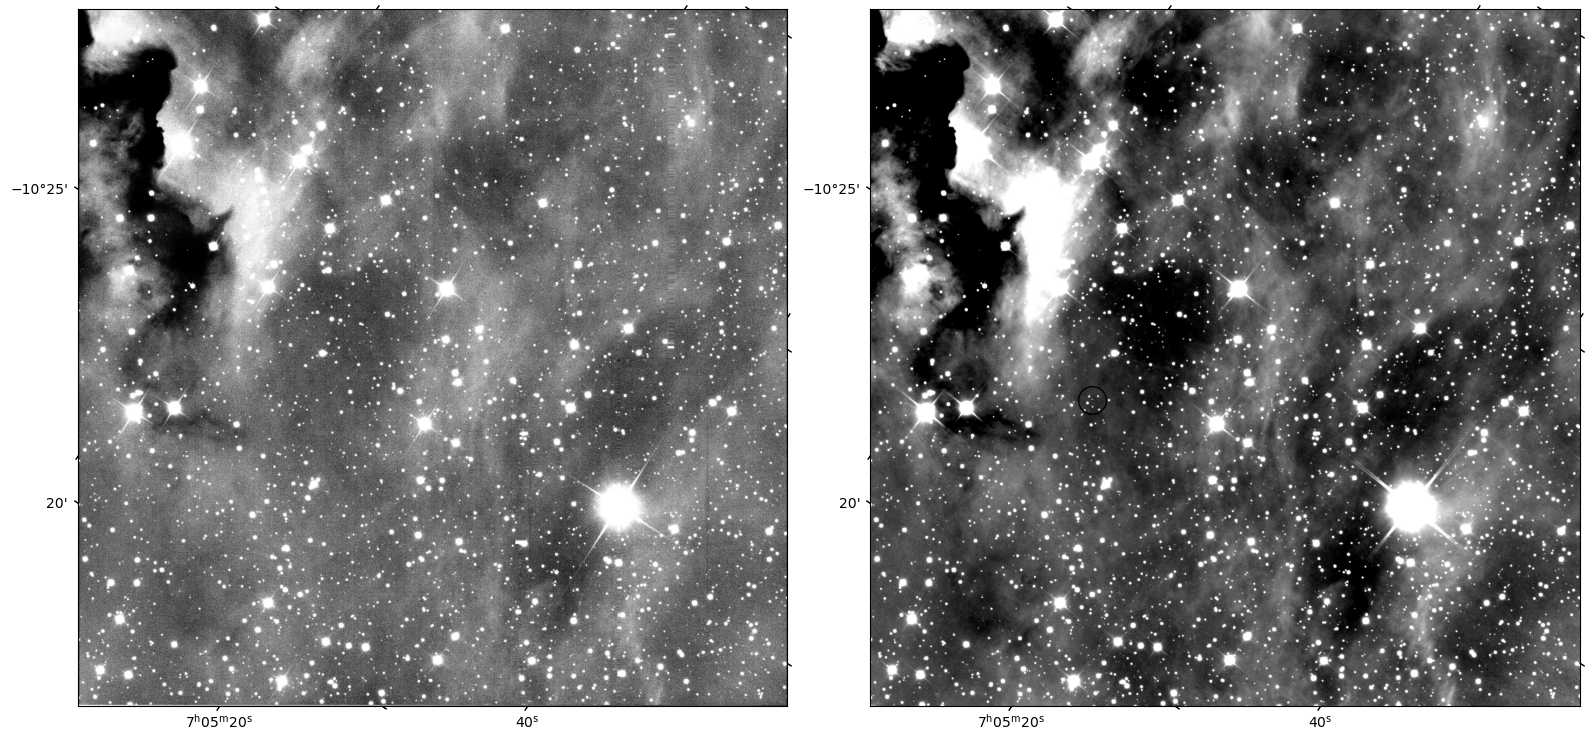

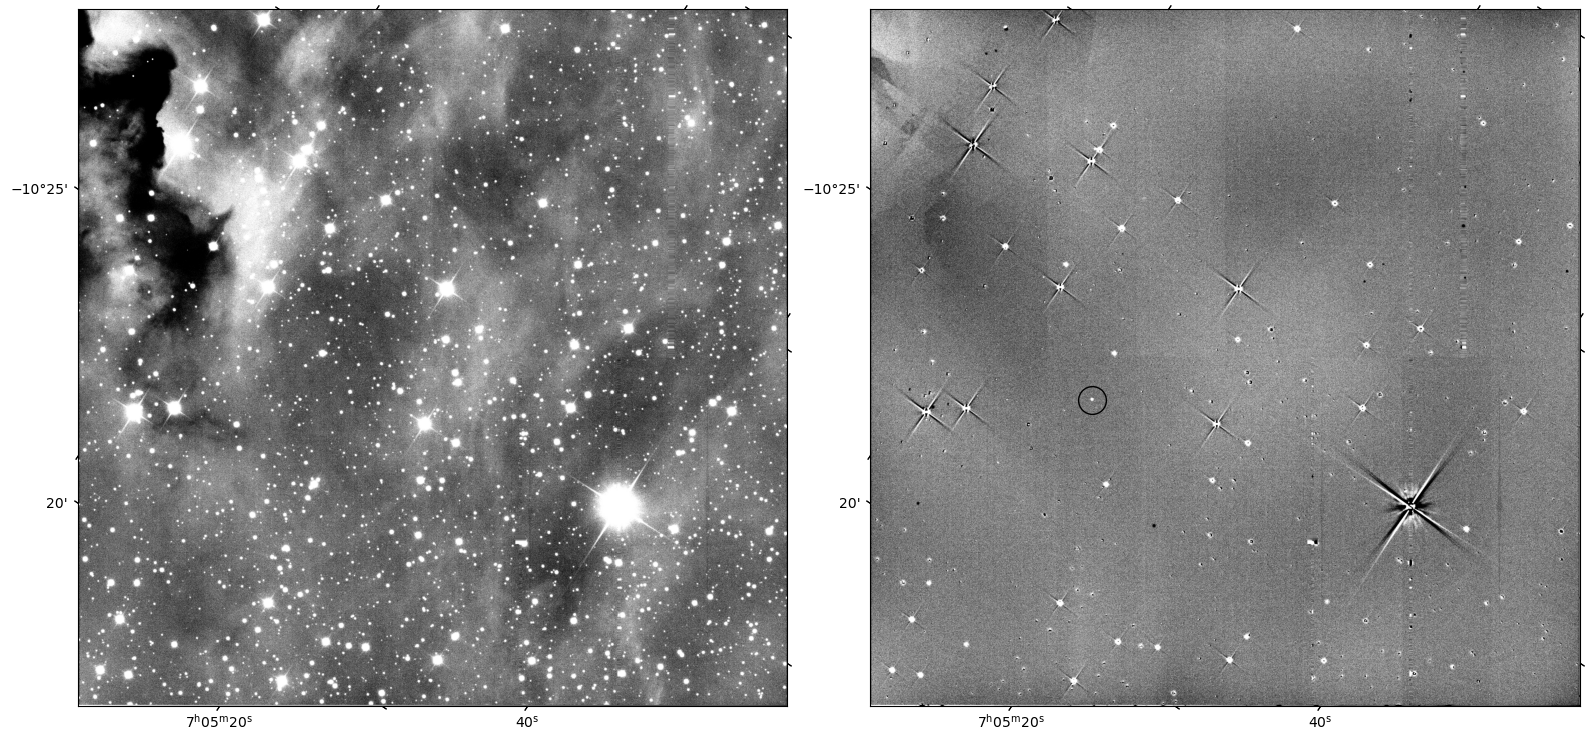

In [56]:
from doppelganger.doppelganger.rubin.utils import plot_side_by_side

remove_figure(plot_side_by_side(visit, visit_injected, coords2 = [(ra, dec)], scale=5))
remove_figure(plot_side_by_side(visit, template, coords2 = [(ra, dec)], scale=5))
remove_figure(plot_side_by_side(visit_injected, diff_injected, coords2 = [(ra, dec)], scale=5))

## Source detection

In [49]:
from lsst.ip.diffim.detectAndMeasure import DetectAndMeasureTask, DetectAndMeasureConfig

config = DetectAndMeasureConfig()
config.detection.thresholdValue = 5.
print(f"`DetectAndMeasure` config value: {config.detection.thresholdValue}")
print(f"`DetectAndMeasure` threshold type: {config.detection.thresholdType}")
print(f"`DetectAndMeasure` polarity type: {config.detection.thresholdPolarity}")

results = DetectAndMeasureTask(config=config).run(visit_injected, template, diff_injected)

`DetectAndMeasure` config value: 5.0
`DetectAndMeasure` threshold type: pixel_stdev
`DetectAndMeasure` polarity type: both


In [50]:
diaSources_df = results.getDict()["diaSources"].asAstropy().to_pandas()
diaSources_df["coord_ra"] = np.rad2deg(diaSources_df["coord_ra"])
diaSources_df["coord_dec"] = np.rad2deg(diaSources_df["coord_dec"])

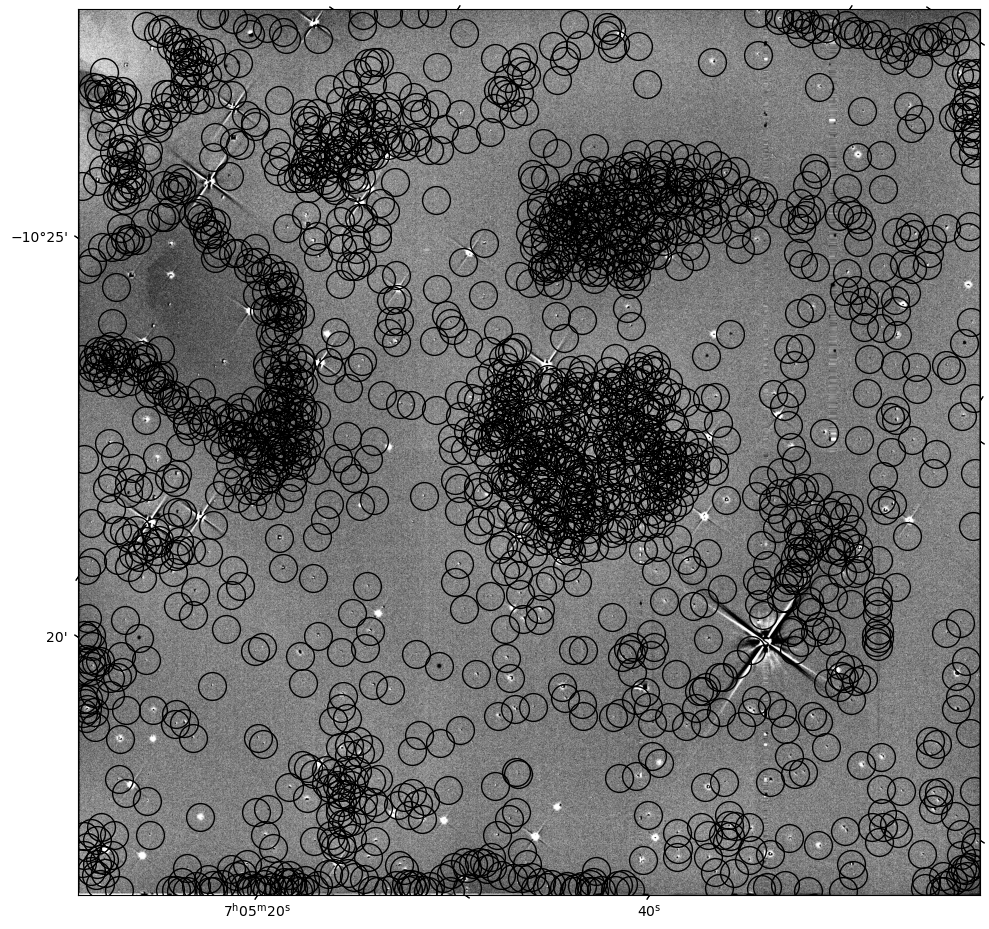

In [51]:
from doppelganger.doppelganger.rubin.utils import plot_with_coords, remove_figure

remove_figure(plot_with_coords(diff_injected, diaSources_df[["coord_ra", "coord_dec"]].values, scale=5))

### Filtering

In [52]:
# a wrapper for making sure how many sources we cut at each step
def verbose(func):
    def msg_wrapper(df: pd.DataFrame, *args, **kwargs):
        before_cut = len(df)
        df = func(df, *args, *kwargs)
        after_cut = len(df)
        print(f"{func.__name__} cut {before_cut - after_cut} rows")
        return df
    return msg_wrapper

In [53]:
@verbose
def filter_nonneg(df: pd.DataFrame) -> pd.DataFrame:
    mask = ~df["is_negative"]
    return df[mask].drop(columns=["is_negative"]).reset_index(drop=True)
    
@verbose
def filter_flags(df: pd.DataFrame) -> pd.DataFrame:
    mask = (
        df["base_PixelFlags_flag_nodata"] |
        df["base_PixelFlags_flag_cr"] |
        # next flags are from Liu 2024
        df["base_PixelFlags_flag_saturated"] |
        df["base_PixelFlags_flag_saturatedCenter"] |
        df["base_PixelFlags_flag_suspect"] |
        df["base_PixelFlags_flag_suspectCenter"] |
        df["base_PixelFlags_flag_offimage"] |
        df["base_PixelFlags_flag_edge"] |
        df["base_PixelFlags_flag_bad"] |
        df["ip_diffim_DipoleFit_classification"] |
        df["ip_diffim_DipoleFit_classificationAttempted"] |
        # df["base_SdssShape_flag"] |  # this flag does not exist
        # df["base_GaussianFlux_flag_badShape"] |   # this flag does not exist
        df["slot_Shape_flag"] |
        df["base_PixelFlags_flag_streak"]
    )
    return df[~mask].reset_index(drop=True)

diaSources_df_ = filter_flags(filter_nonneg(diaSources_df))

filter_nonneg cut 818 rows
filter_flags cut 771 rows


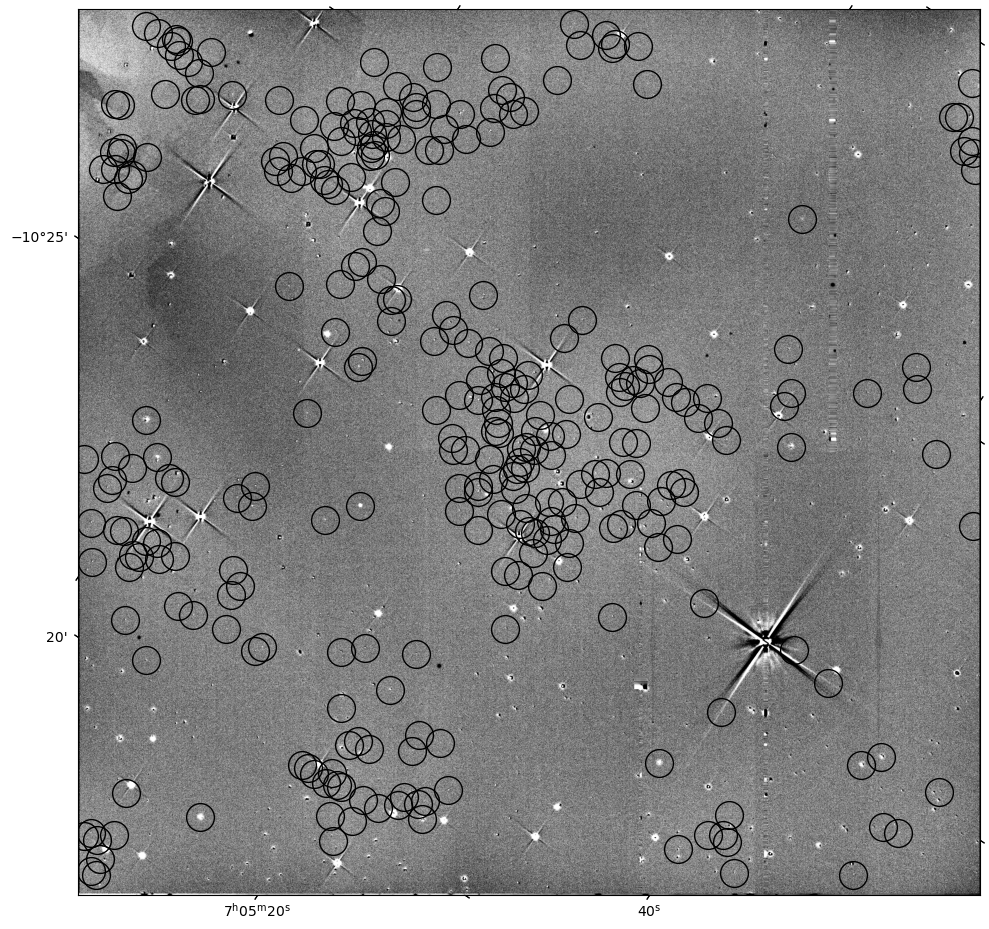

In [54]:
from doppelganger.doppelganger.rubin.utils import plot_with_coords, remove_figure

remove_figure(plot_with_coords(diff_injected, diaSources_df_[["coord_ra", "coord_dec"]].values, scale=5))

## Exporting 

In [ ]:
from lsst.afw.image import ExposureF


def str_visit_ref(visit_ref: DatasetRef) -> str:
    return f"{visit_ref.dataId["instrument"]}_{visit_ref.dataId['visit']}__{visit_ref.dataId['detector']}_{visit_ref.dataId['physical_filter']}"

def reconstruct_template(science: ExposureF, diff: ExposureF):
    template = science.clone()
    template.setImage(ImageF(science.getImage().array - diff.getImage().array))
    return template

config = DetectAndMeasureConfig()
config.detection.thresholdValue = 5.
print(f"`DetectAndMeasure` config value: {config.detection.thresholdValue}")
print(f"`DetectAndMeasure` threshold type: {config.detection.thresholdType}")
print(f"`DetectAndMeasure` polarity type: {config.detection.thresholdPolarity}")


for i in range(len(visits)):
    print(f"on visit {i + 1} / {len(visits)}..")
    visit_ref = visits_refs[i]
    visit_injected, _ = inject((visit := visits[i]), ra, dec,  mag_visits[i])
    diff_injected, _ = inject((diff := diffs[i]), ra, dec,  mag_visits[i])
    template = reconstruct_template(visit_injected, diff_injected)
    results = DetectAndMeasureTask(config=config).run(visit_injected, template, diff_injected)
    diaSources_df = results.getDict()["diaSources"].asAstropy().to_pandas()
    diaSources_df.to_csv(f"data/250924_dp1_simulation/sources_{str_visit_ref(visit_ref)}.csv")